![image.png](attachment:image.png)

In [8]:
from google.colab import files

files.upload()

In [9]:
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

In [10]:
# ! kaggle datasets download -d andrewmvd/car-plate-detection

In [11]:
# ! mkdir ./kaggle
# ! mkdir ./kaggle/input
# ! unzip car-plate-detection.zip -d ./kaggle/input

This dataset contains 433 images with bounding box annotations of the car license plates within the image. Our goal here is to train a convolutional neural network capable of locating licenses plate on new images.

## Preparation of the data

Import libraries

In [12]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob
from keras.callbacks import ModelCheckpoint

We display the files in Kaggle repertoire :

In [13]:
import os
for dirname, _, filenames in os.walk('./kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./kaggle/input/annotations/Cars412.xml
./kaggle/input/annotations/Cars247.xml
./kaggle/input/annotations/Cars72.xml
./kaggle/input/annotations/Cars367.xml
./kaggle/input/annotations/Cars121.xml
./kaggle/input/annotations/Cars291.xml
./kaggle/input/annotations/Cars66.xml
./kaggle/input/annotations/Cars397.xml
./kaggle/input/annotations/Cars290.xml
./kaggle/input/annotations/Cars284.xml
./kaggle/input/annotations/Cars426.xml
./kaggle/input/annotations/Cars31.xml
./kaggle/input/annotations/Cars128.xml
./kaggle/input/annotations/Cars346.xml
./kaggle/input/annotations/Cars181.xml
./kaggle/input/annotations/Cars194.xml
./kaggle/input/annotations/Cars429.xml
./kaggle/input/annotations/Cars241.xml
./kaggle/input/annotations/Cars245.xml
./kaggle/input/annotations/Cars101.xml
./kaggle/input/annotations/Cars47.xml
./kaggle/input/annotations/Cars22.xml
./kaggle/input/annotations/Cars212.xml
./kaggle/input/annotations/Cars105.xml
./kaggle/input/annotations/Cars211.xml
./kaggle/input/annotations/Car

We create the variable X containing all the images of cars by resizing them to 200 * 200.



In [14]:
IMAGE_SIZE = 200

In [15]:
img_dir = "./kaggle/input/images" # Enter Directory of all images
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() #We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes
X=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))


We create the variable y containing all the bounding boxe annotations (label).
Before that, we will have to resize the annotations so that it fits the new size of the images (200*200). We create a function resizeannotation for that.

In [16]:
from lxml import etree
def resizeannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]


In [17]:
path = './kaggle/input/annotations'
text_files = ['./kaggle/input/annotations/'+f for f in sorted(os.listdir(path))]
y=[]
for i in text_files:
    y.append(resizeannotation(i))

In [18]:
resizeannotation("./kaggle/input/annotations/Cars147.xml")

[168, 126, 90, 93]

In [19]:
y[0]

[167, 129, 90, 93]

We check X et y shape

In [20]:
np.array(X).shape

(433, 200, 200, 3)

In [21]:
np.array(y).shape

(433, 4)

And we display the first eighteen image of the dataset :

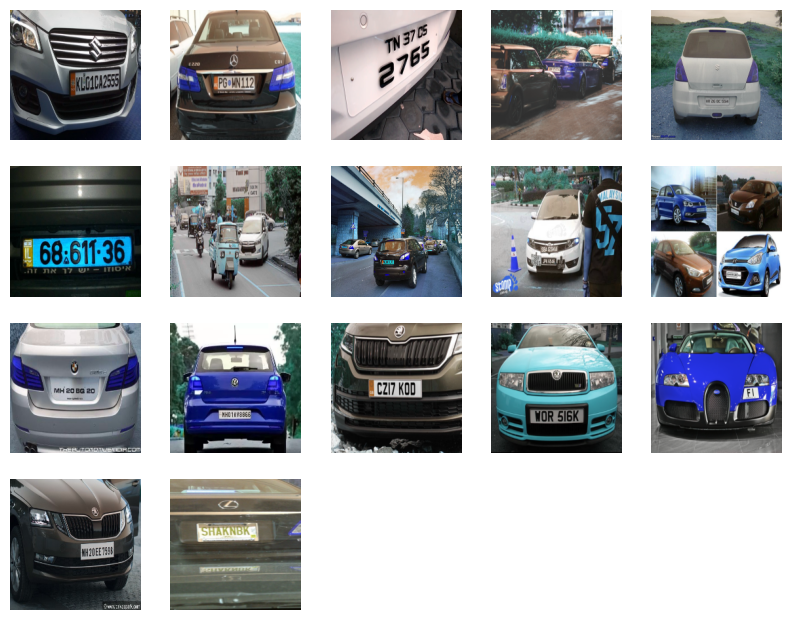

In [22]:
plt.figure(figsize=(10,20))
for i in range(0,17) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(X[i])

We can draw the rectangle containing the license plate using the OpenCV library

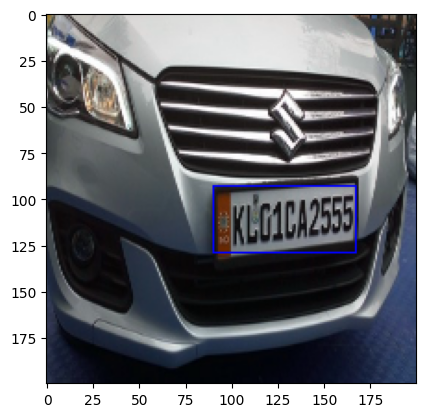

In [23]:
#Example with the first image of the dataset
image = cv2.rectangle(X[0],(y[0][0],y[0][1]),(y[0][2],y[0][3]),(0, 0, 255))
plt.imshow(image)
plt.show()


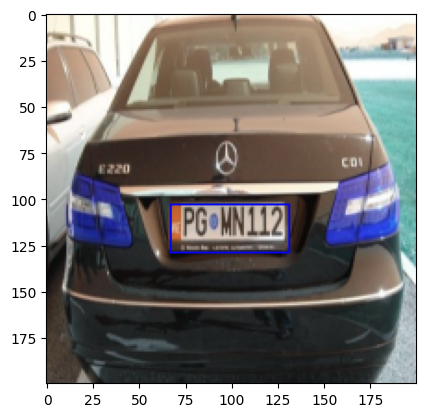

In [24]:
#Example with the second image of the dataset
image = cv2.rectangle(X[1],(y[1][0],y[1][1]),(y[1][2],y[1][3]),(0, 0, 255))
plt.imshow(image)
plt.show()


We prepare the data for the CNN :

In [25]:
#Transforming in array
X=np.array(X)
y=np.array(y)

In [26]:
#Renormalisation
X = X / 255
y = y / 255

We split our dataset in two : training set/testing set

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

## Convolutionnal Neural Network

In [28]:
from keras.models import Sequential

from keras.layers import Dense, Flatten

from keras.applications.vgg16 import VGG16

In [29]:
# Create the model
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

2023-12-14 11:42:34.237634: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-14 11:42:34.421658: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-14 11:42:34.421694: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-14 11:42:34.424289: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-14 11:42:34.424324: I tensorflow/compile

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 128)               2359424   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 17099140 (65.23 MB)
Trainable params: 2384

In [30]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [31]:
! mkdir models
filepath = os.path.join("./models","mat-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',period=1)
callbacks_list = [checkpoint]

In [32]:
train = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=40, verbose=1, shuffle=True, callbacks=callbacks_list)

Epoch 1/10


2023-12-14 11:43:05.758801: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2023-12-14 11:43:20.947131: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f62c051d770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-14 11:43:20.947155: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-12-14 11:43:20.957163: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-14 11:43:21.095723: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 [==============================] - ETA: 0s - loss: 0.0302 - accuracy: 0.4704
Epoch 1: val_accuracy improved from -inf to 0.68182, saving model to ./models/mat-01-0.68.hdf5
10/10 [==============================] - 29s 1s/step - loss: 0.0302 - accuracy: 0.4704 - val_loss: 0.0140 - val_accuracy: 0.6818
Epoch 2/10


/home/loukios/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - ETA: 0s - loss: 0.0095 - accuracy: 0.7738
Epoch 2: val_accuracy improved from 0.68182 to 0.81818, saving model to ./models/mat-02-0.82.hdf5
10/10 [==============================] - 14s 1s/step - loss: 0.0095 - accuracy: 0.7738 - val_loss: 0.0072 - val_accuracy: 0.8182
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.0051 - accuracy: 0.8046
Epoch 3: val_accuracy did not improve from 0.81818
10/10 [==============================] - 5s 514ms/step - loss: 0.0051 - accuracy: 0.8046 - val_loss: 0.0056 - val_accuracy: 0.7727
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.0031 - accuracy: 0.8355
Epoch 4: val_accuracy did not improve from 0.81818
10/10 [==============================] - 13s 1s/step - loss: 0.0031 - accuracy: 0.8355 - val_loss: 0.0051 - val_accuracy: 0.7727
Epoch 5/10
10/10 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 0.8560
Epoch 5: val_accuracy improved from 0.81818 to

In [33]:
# Test
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 90.91%


In [34]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

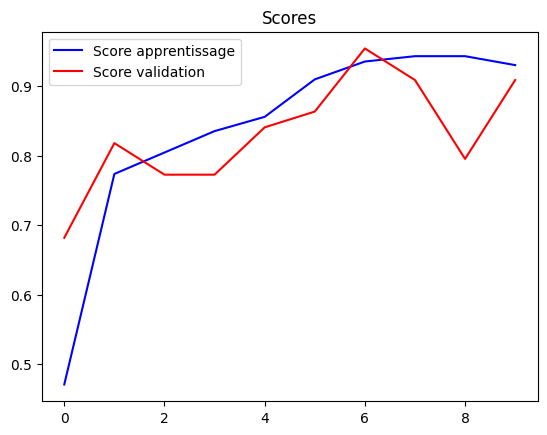

In [35]:
plot_scores(train)

## DETECTION

In [36]:
y_cnn = model.predict(X_test)

2/2 [==============================] - 17s 16s/step


In [37]:
y_cnn.shape

(44, 4)

We can see how our model localize license plates on our testing set :

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

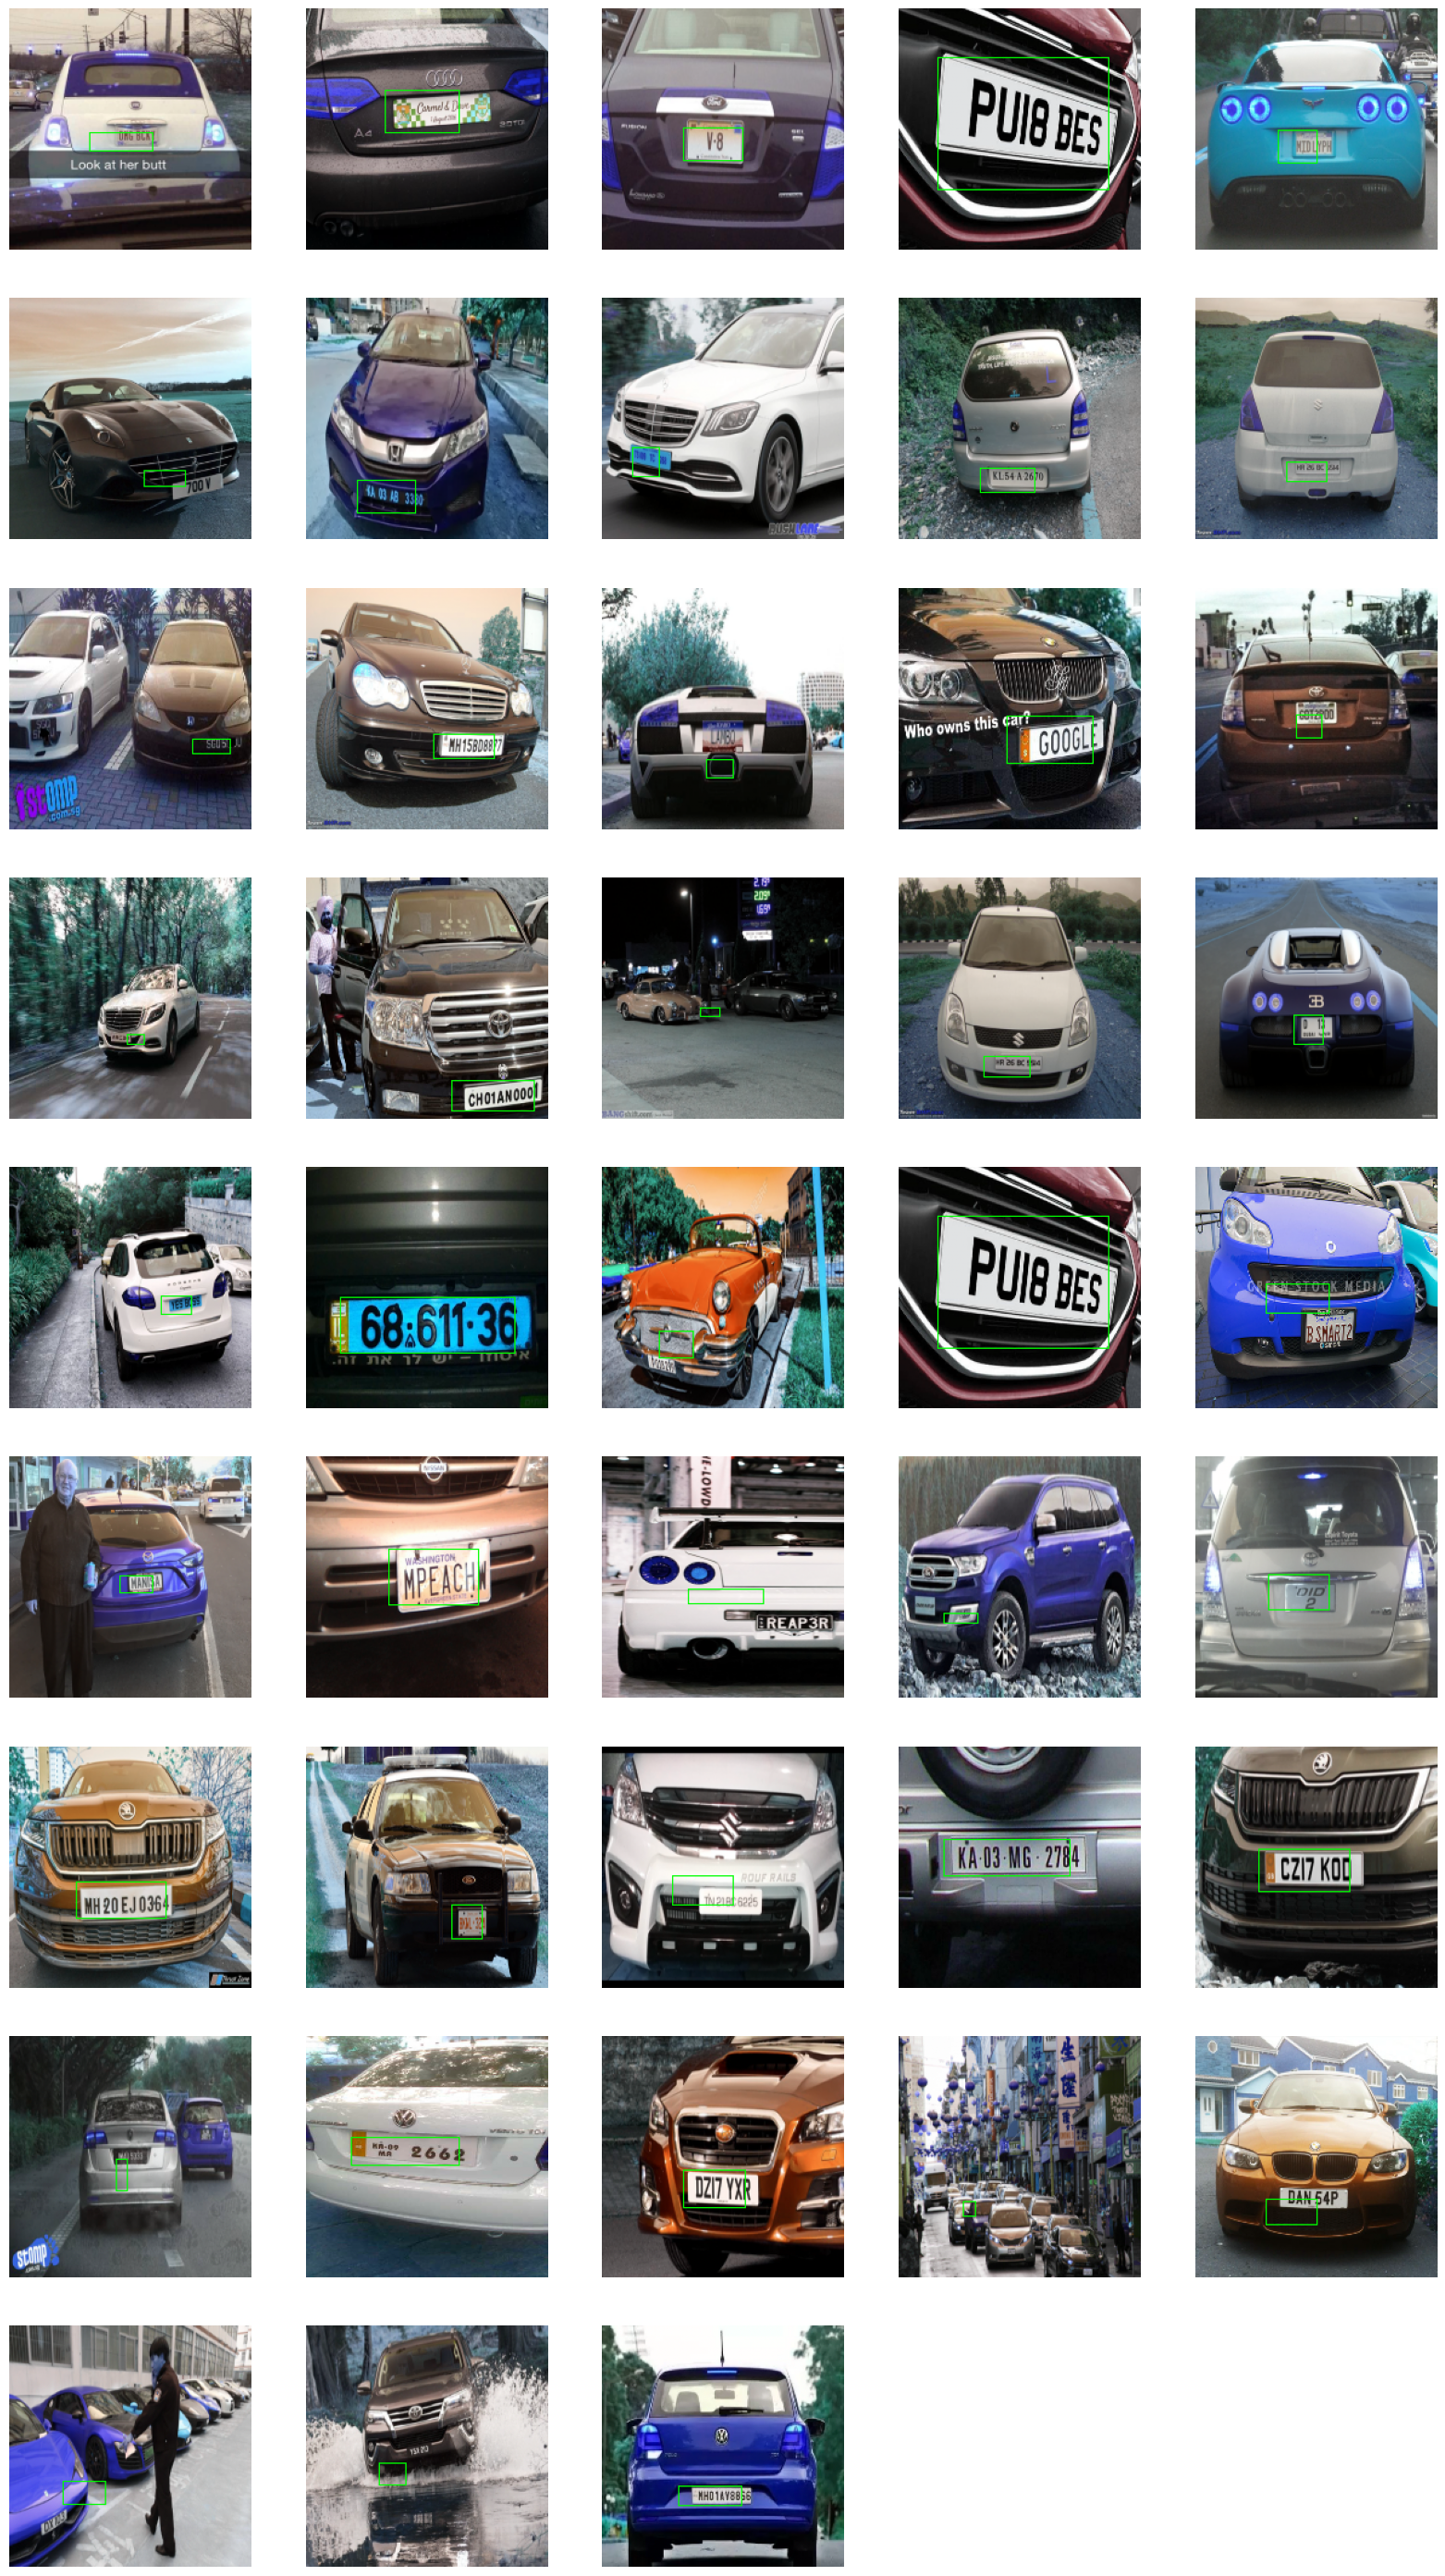

In [38]:
plt.figure(figsize=(20,40))
for i in range(0,43) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    image = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)

